# 2nd Derivative weighted loss function

Notebook exploring the development of a loss function that is weighted based on the second derivative.  

The second derivative has a large negative value at the stick -> slip transition and large positive value at the slip -> stick transition. A loss function weighted by the second derivative (with possible seperate weightings dependent on whether it is positive or negative) should help any ML model to prioritise learning to accurately forecast start and end of failures.


Questions:
- How should weightings be normalised? Based on 2nd derivative distribution across whole training dataset?

## Setup

In [5]:
# Import libraries
import sys
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch

MAIN_DICT = "/gws/nopw/j04/ai4er/users/jpoff/earthquake-predictability" # TODO: update to use utils.paths instead
sys.path.append(MAIN_DICT)

# Import local modules
from utils.dataset import SlowEarthquakeDataset
import utils.general_functions as gfn
import utils.data_preprocessing as data_preprocessing

In [6]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load data

In [7]:
# Import data - TODO update to import all datasets
EXP = "p4679"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df

,obs_shear_stress,obs_normal_stress,obs_ecdisp,time
0,5.091520,6.986740,22107.1104,0.000
1,5.090652,6.988410,22109.7823,0.001
2,5.089989,6.986299,22103.7900,0.002
3,5.089492,6.985970,22109.2161,0.003
4,5.088243,6.987547,22108.5900,0.004
...,...,...,...,...
301716,4.979753,6.987299,25641.7379,301.716
301717,4.979841,6.988011,25642.8180,301.717
301718,4.980150,6.988861,25646.0429,301.718
301719,4.979985,6.990632,25639.8351,301.719


In [8]:
# Seperating out obs_shear_stress variable - TODO: check if this is standard practice in other scripts/notebooks
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(301721,)

Text(0.5, 1.0, 'Raw Shear Stress Data, p4679')

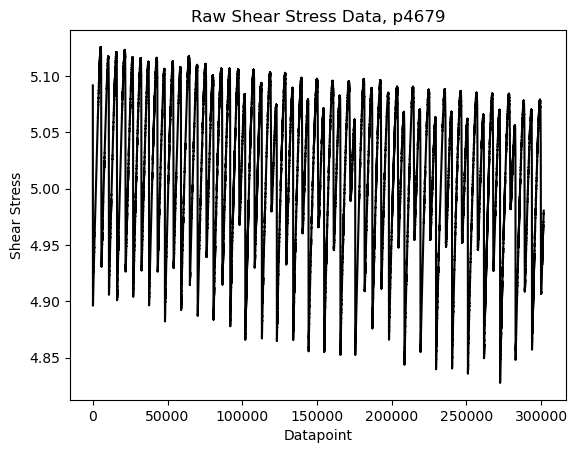

In [27]:
# Visualise data
plt.plot(shear_stress_df, 'k')
plt.ylabel("Shear Stress")
plt.xlabel("Datapoint")
plt.title(f"Raw Shear Stress Data, {EXP}")


## Data pre-processing

In [13]:
# Data downsampling - TODO: update to use standardised downsampling/smoothing factors provided by Tom
SMOOTHING_WINDOW = 1
DOWNSAMPLING_FACTOR = 50

df_ds = data_preprocessing.moving_average_causal_filter(shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_ds.shape

(6034,)

Text(0.5, 1.0, 'Downsampled Shear Stress Data, p4679')

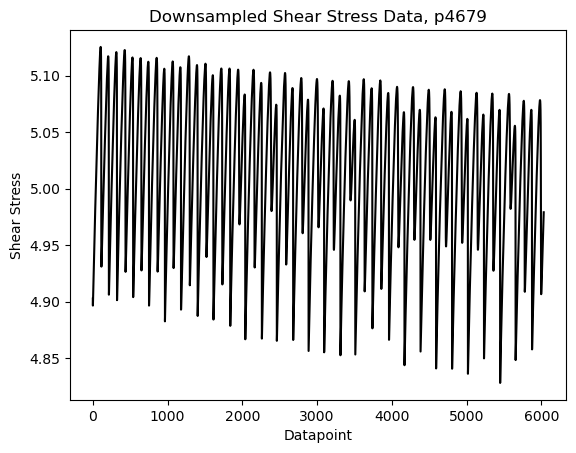

In [30]:
# Plot downsampled data - TODO: update to plot all datasets
plt.plot(df_ds, 'k')
plt.ylabel("Shear Stress")
plt.xlabel("Datapoint")
plt.title(f"Downsampled Shear Stress Data, {EXP}")

## Further smoothing

We want the derivates used for weighting the loss function to have "all" noise removed and be a smooth line.

In [ ]:
# Determining optimal smoothing window for each dataset - TODO: determine what this should be

## Calculate derivates

TODO:
- Calculate first and second derivatives of extra smoothed lines using simple difference method (causal or not??)
- Plot distribution of derivatives for each dataset
- Determine relative scaling parameters/function for each dataset in order to normalise/scale the first/second derivatives

In [15]:
# # Calculate first derivative
# # np.gradient calculates average difference to adjacent points
# df[] = np.gradient(df["obs_shear_stress"])
# test


array([-8.6757e-04, -7.6534e-04, -5.8022e-04, ...,  7.1835e-05,
        1.1328e-04,  3.9234e-04])

In [21]:
# Create tensor
true_tensor = torch.tensor(df_ds.values, dtype=torch.float32, requires_grad=True)

true_tensor.shape

torch.Size([6034])

In [33]:
# Calculate first derivative using autograd
first_derivative = torch.autograd.grad(torch.sum(true_tensor), true_tensor, create_graph=True)[0]

first_derivative.shape

torch.Size([6034])

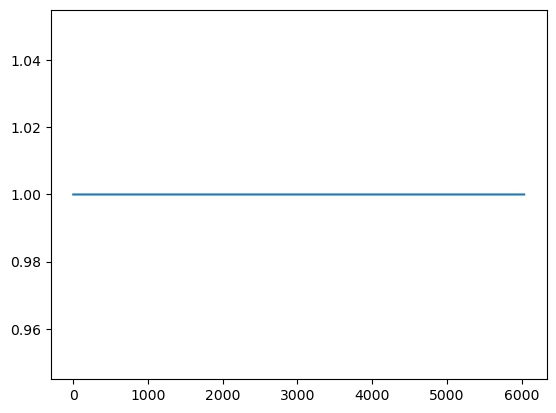

In [34]:
plt.plot(first_derivative) # all the derivatives are just 1s!

In [ ]:
# Calculate second derivative

## Custom loss function

TODO: Finish the function

Additional inputs to add to function: 
- extra smoothing window (or just dataset name and have these defined in the function)
- derivative scaling parameters (again could have these defined in the function based on datatset name)


In [35]:
# Custom loss function based around Andrew's suggestions
def custom_loss1(y_true, y_pred):
    """
    Description
    """
    import torch
    import torch.nn as nn

    square_error = (y_true - y_pred)**2

    first_derivative = ...
    second_derivative = ...

    weights = ... # should depend on magnitude of exp or ReLU of second derivative

    weighted_loss = torch.mean(weights * square_error) # or torch.sum 

    return weighted_loss


Final TODO: Write this function as a script and with others work out how it is opererationalised in the existing training pipelines.